In [1]:
import aemeasure
import pandas as pd
import json
import os
import seaborn
import itertools
from random import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

## Load experiment data

In [2]:
experiment_table = aemeasure.read_as_pandas_table("results_/be_smart_60it_60sec")
experiment_table

,stagnation_detection,n_concrete,instance,time_limit,iterations,cds_iter_stop,cds_optimize_stop,cds_found_solution_size,cds_proven_optimal,cds_grb_status,...,cds_iter_start,runtime,stdout,stderr,timestamp,hostname,argv,git_revision,python_env,cwd
0,False,236,fiasco-case-study-2018-05-09_16-02-56,60.0,60,"[1677939230880, 1677939231571, 1677939233397, ...","[1677939230880, 1677939231571, 1677939233397, ...","[71, 79, 86, 95, 107, 115, 119, 123, 129, 137,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",...,"[1677939230392, 1677939230880, 1677939231571, ...",1439.552149,,,2023-03-04T15:37:48.943140,algry02,/ibr/home/ggehrke/anaconda3/envs/quantum/lib/p...,6cf1e3c84519cd958a6d9ecec9b2f1ba5f634ee0,"[{'name': 'networkx', 'path': '/misc/ibr/home/...",/misc/ibr/home/ggehrke/git/software-configurat...
1,True,30,toybox-case-study-2008-01-05_16-40-40,60.0,60,"[1677942569744, 1677942570144, 1677942581624, ...","[1677942569743, 1677942570143, 1677942581624, ...","[8, 8, 8, 8, 8]","[0, 0, 0, 0, 1]","[2, 2, 2, 2, 2]",...,"[1677942568552, 1677942569744, 1677942570144, ...",77.628212,,,2023-03-04T16:10:46.147160,algry02,/ibr/home/ggehrke/anaconda3/envs/quantum/lib/p...,6cf1e3c84519cd958a6d9ecec9b2f1ba5f634ee0,"[{'name': 'networkx', 'path': '/misc/ibr/home/...",/misc/ibr/home/ggehrke/git/software-configurat...
2,True,545,busybox-case_study-2008-09-01_15-26-12,60.0,60,"[1677933605770, 1677933618730, 1677933631739, ...","[1677933605770, 1677933618729, 1677933631739, ...","[5, 10, 14, 14, 18, 18, 20, 21, 20, 23, 27, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 9, 2, ...",...,"[1677933605755, 1677933605770, 1677933618730, ...",1903.044956,,,2023-03-04T14:11:38.285239,algry02,/ibr/home/ggehrke/anaconda3/envs/quantum/lib/p...,6cf1e3c84519cd958a6d9ecec9b2f1ba5f634ee0,"[{'name': 'networkx', 'path': '/misc/ibr/home/...",/misc/ibr/home/ggehrke/git/software-configurat...
3,False,30,toybox-case-study-2007-12-03_18-53-00,60.0,60,"[1677935279942, 1677935280193, 1677935285031, ...","[1677935279942, 1677935280193, 1677935285031, ...","[8, 8, 8, 8, 8]","[0, 0, 0, 0, 1]","[2, 2, 2, 2, 2]",...,"[1677935279581, 1677935279942, 1677935280193, ...",56.203708,,,2023-03-04T14:08:55.534076,algry02,/ibr/home/ggehrke/anaconda3/envs/quantum/lib/p...,6cf1e3c84519cd958a6d9ecec9b2f1ba5f634ee0,"[{'name': 'networkx', 'path': '/misc/ibr/home/...",/misc/ibr/home/ggehrke/git/software-configurat...
4,False,237,uclibc-case-study-2016-11-03_20-37-48,60.0,60,"[1677938901533, 1677938903690, 1677938905157, ...","[1677938901533, 1677938903690, 1677938905157, ...","[84, 148, 162, 181, 196, 217, 230, 235, 251, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",...,"[1677938901452, 1677938901533, 1677938903690, ...",1922.146024,,,2023-03-04T15:40:16.879633,algry02,/ibr/home/ggehrke/anaconda3/envs/quantum/lib/p...,6cf1e3c84519cd958a6d9ecec9b2f1ba5f634ee0,"[{'name': 'networkx', 'path': '/misc/ibr/home/...",/misc/ibr/home/ggehrke/git/software-configurat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,False,354,soletta-case-study-2016-02-24_15-26-54,60.0,60,"[1677965624413, 1677965624437, 1677965624442, ...","[1677965624413, 1677965624437, 1677965624442, ...","[8, 8, 8, 8, 8, 8, 20, 29, 32, 32, 35, 35, 35,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, ...",...,"[1677965624391, 1677965624413, 1677965624437, ...",1741.110931,,,2023-03-04T23:02:44.491309,mintbox,/home/gabriel/anaconda3/envs/quantum/lib/pytho...,6cf1e3c84519cd958a6d9ecec9b2f1ba5f634ee0,"[{'name': 'yt-dlp', 'path': '/home/gabriel/.lo...",/home/gabriel/git/software-configuration-probl...
79,False,246,soletta-case-study-2015-09-02_17-37-27,60.0,60,"[1677948611002, 1677948612727, 1677948613999, ...","[1677948611002, 1677948612727, 1677948613999, ...","[11, 11, 17, 

In [3]:
# Load reference data

best_ubs = dict()

with open("lower_bounds_candp.json") as f:
    best_ubs = json.load(f)

best_ubs

{'busybox-case_study-2010-04-18_22-09-30': 21,
 'uclibc-case-study-2010-09-15_12-31-22': 512,
 'busybox-case_study-2010-01-20_02-47-37': 21,
 'busybox-case_study-2008-07-19_09-27-19': 27,
 'soletta-case-study-2016-06-02_14-58-43': 37,
 'soletta-case-study-2015-07-06_15-16-16': 16,
 'busybox-case_study-2008-05-27_08-41-32': 24,
 'busybox-case_study-2008-11-22_18-41-41': 24,
 'uclibc-case-study-2008-10-27_22-02-54': 512,
 'toybox-case-study-2007-11-27_00-57-42': 8,
 'uclibc-case-study-2016-11-27_22-32-11': 310,
 'busybox-case_study-2009-12-07_01-37-34': 21,
 'busybox-case_study-2008-04-22_00-16-29': 24,
 'busybox-case_study-2009-06-18_19-59-51': 24,
 'soletta-case-study-2015-09-02_17-37-27': 30,
 'soletta-case-study-2015-12-28_13-48-28': 30,
 'busybox-case_study-2008-08-22_08-25-26': 27,
 'uclibc-case-study-2016-12-23_07-53-31': 310,
 'soletta-case-study-2016-01-29_14-02-27': 30,
 'busybox-case_study-2008-01-05_03-26-41': 25,
 'busybox-case_study-2008-11-07_01-12-16': 24,
 'soletta-case-

# Create and export Plots

In [4]:
seaborn.set_theme()

In [5]:
datapoints = list()

for instance in experiment_table["instance"].unique():
    rows = experiment_table[experiment_table["instance"] == instance]

    for index, row in rows.iterrows():
        if (len(row["cds_global_lb"]) == 0):
            print("Warning: Entry with empty lists skipped")
            continue
        
        i = 1
        for (global_lb, lb, iter_start, iter_stop, nbhd_start, nbhd_stop, nbhd_size) in zip(row["cds_global_lb"], row["cds_found_solution_size"], row["cds_iter_start"], row["cds_iter_stop"], row["cds_nbhd_start"], row["cds_nbhd_stop"], row["cds_nbhd_free_size"]):
            d = dict()
            d["instance"] = instance
            #d["instance"] = instance.split("-")[0]
            d["iteration"] = i
            d["time in seconds"] = sum(row["cds_iter_stop"][j] - row["cds_iter_start"][j] for j in range(0, i)) / 1000.0
            d["stagnation detection"] = row["stagnation_detection"]
            #d["global cds size"] = global_lb
            d["cds score (% of best known)"] = 100.0 * (global_lb / best_ubs[instance])
            #d["cds size"] = lb
            #d["nbhd_time"] = (nbhd_stop - nbhd_start) / 1000.0
            #d["ip_time"] = (iter_stop - iter_start) / 1000.0 - d["nbhd_time"]
            #d["free edges"] = nbhd_size
            datapoints.append(d)
            i += 1
        

In [6]:
data = pd.DataFrame(data=datapoints)
data

,instance,iteration,time in seconds,stagnation detection,cds score (% of best known)
0,fiasco-case-study-2018-05-09_16-02-56,1,0.488,False,37.967914
1,fiasco-case-study-2018-05-09_16-02-56,2,1.179,False,42.245989
2,fiasco-case-study-2018-05-09_16-02-56,3,3.005,False,45.989305
3,fiasco-case-study-2018-05-09_16-02-56,4,4.054,False,50.802139
4,fiasco-case-study-2018-05-09_16-02-56,5,5.392,False,57.219251
...,...,...,...,...,...
4330,busybox-case_study-2008-10-27_21-30-39,55,1549.934,True,100.000000
4331,busybox-case_study-2008-10-27_21-30-39,56,1565.025,True,100.000000
4332,busybox-case_study-2008-10-27_21-30-39,57,1625.503,True,100.000000
4333,busybox-case_study-2008-10-27_21-30-39,58,1650.530,True,100.000000


{'fiasco', 'soletta', 'busybox', 'uclibc'}
0 busybox
1 fiasco
2 soletta
3 uclibc


<Figure size 640x480 with 0 Axes>

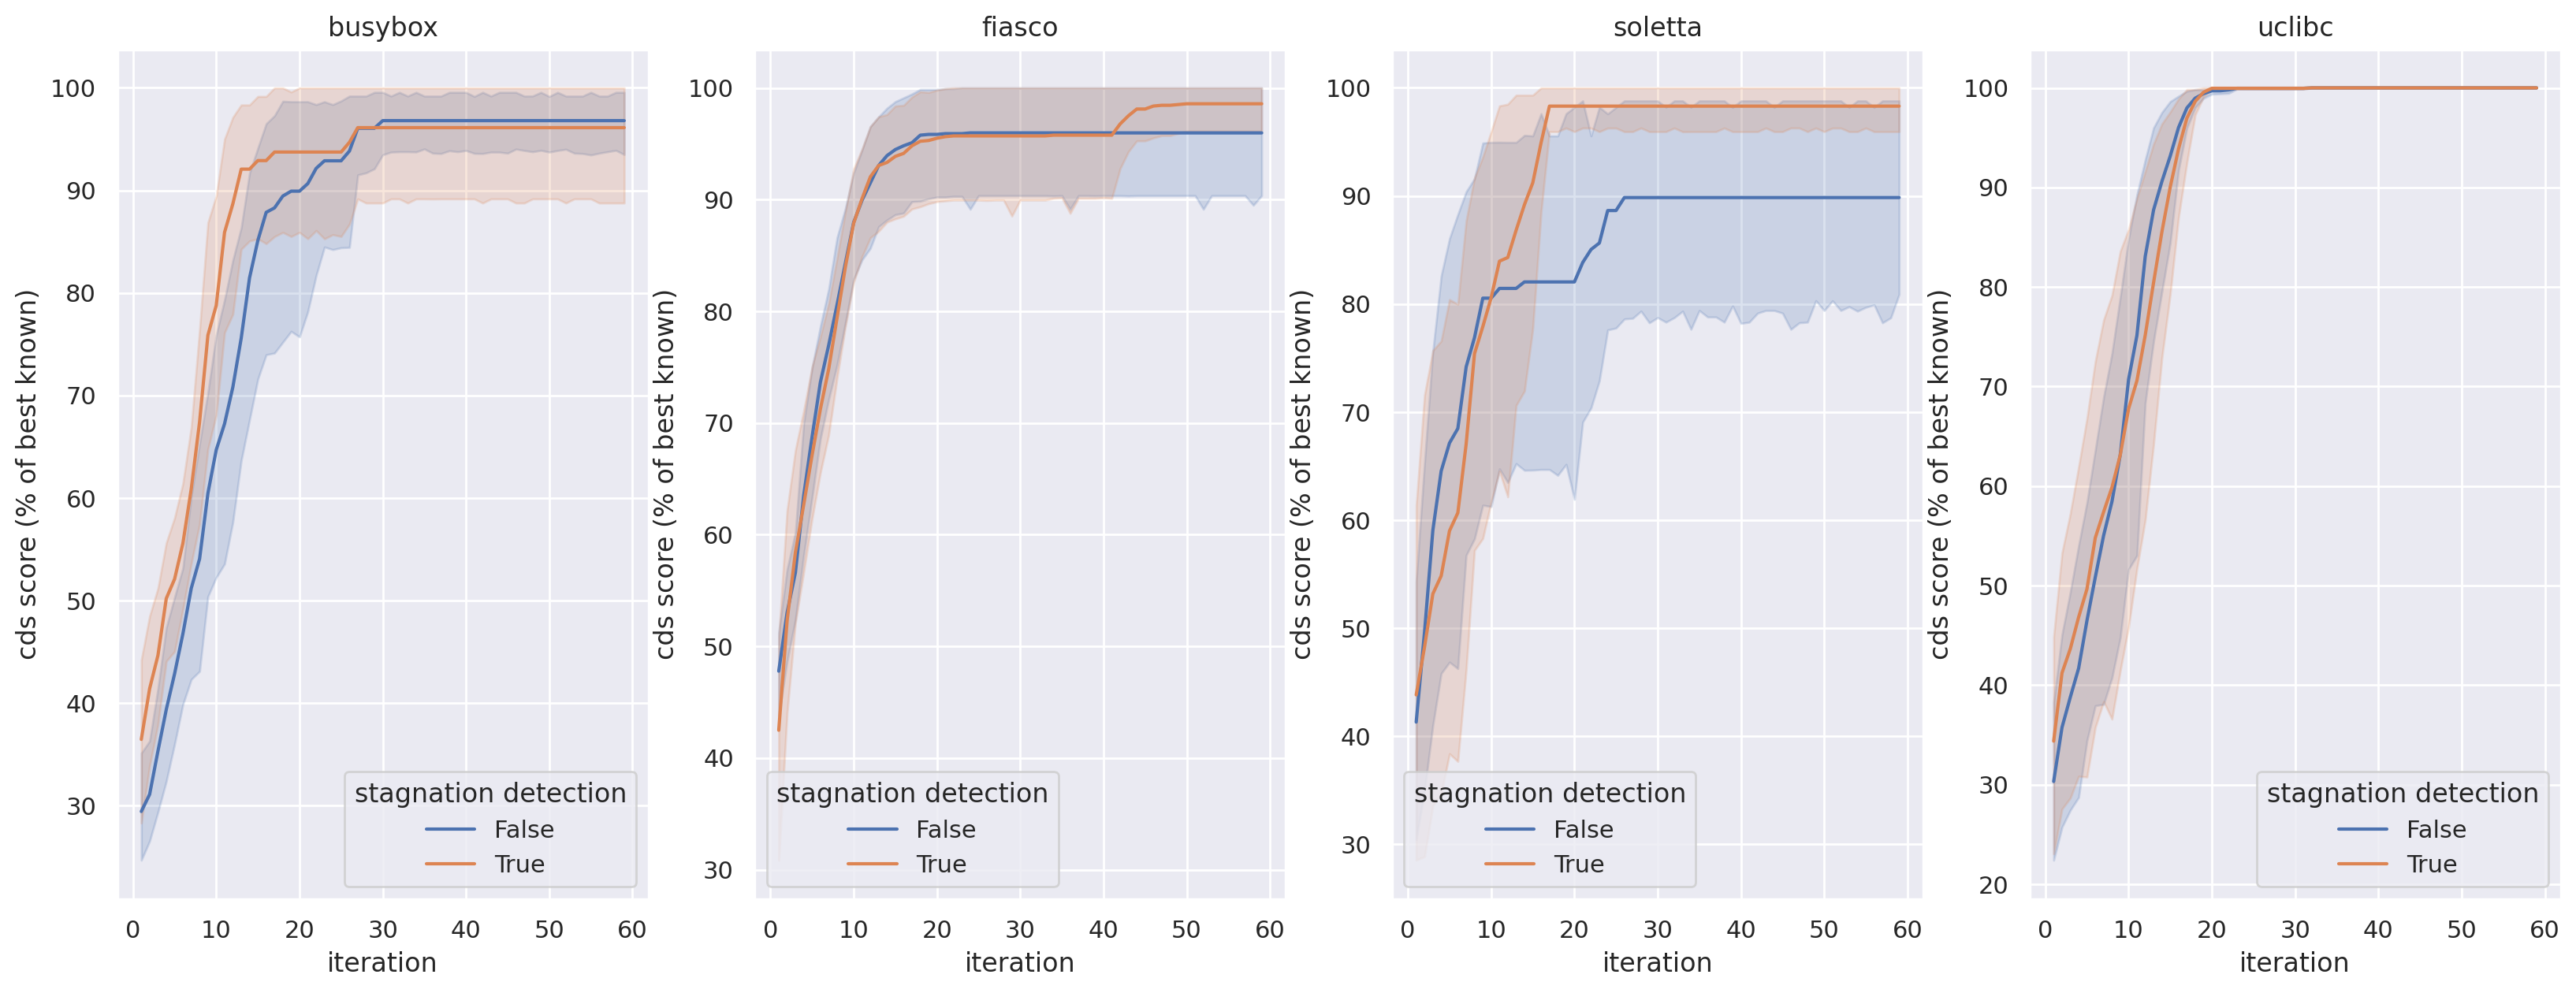

In [7]:
instances = set(data["instance"].map(lambda s: s.split("-")[0]).unique())
instances = instances - set(("toybox",))
print(instances)

plt.cla()
plt.clf()
fig, ax = plt.subplots(1, len(instances))
fig.set_dpi(200)
fig.set_size_inches(len(instances) * 5, 7)

for i, instance in enumerate(sorted(instances)):
    print(i, instance)
    subdata = data[data["instance"].map(lambda s: s.startswith(instance))]
    seaborn.lineplot(data=subdata, ax = ax[i], x="iteration", y="cds score (% of best known)", hue="stagnation detection").set_title(instance)

plt.savefig(f"{instance}_comparison.pdf", bbox_inches='tight')

In [8]:
# molten_data = dict()

# for instance, data in datapoints.items():
#     df_o = pd.DataFrame(data)
#     molten_data[instance] = df_o.melt(["instance", "iteration", "force number of free edges"], var_name="variable", value_name="cds score")

In [9]:
# plt.cla()
# plt.clf()

# for instance, df in molten_data.items():
#     plt.cla()
#     plt.clf()
#     fig, ax = plt.subplots(2,1)
#     fig.set_dpi(200)
#     fig.set_size_inches(12, 10)

#     seaborn.lineplot(data=df, ax = ax[0], x="iteration", y="number of edges", style="variable", style_order=["global cds size", "cds size", "free edges"], hue="adaptive sequential fixing").set_title(instance)
#     seaborn.lineplot(data=df, ax = ax[1], x="iteration", y="number of edges", style="variable", style_order=["nbhd_time", "ip_time"], hue="adaptive sequential fixing")
#     plt.ylabel("time in seconds")
#     plt.savefig(f"{instance}_comparison.pdf", bbox_inches='tight')
#     print(instance)

In [10]:
# import zipfile

# INSTANCE_ZIP_PATH = "/home/gabriel/git/software-configuration-problem-cpp/instances/exported_instances.zip"
# def get_instance_archive() -> zipfile.ZipFile:
#     return zipfile.ZipFile(INSTANCE_ZIP_PATH, "r")


# def get_instance_names():
#     with get_instance_archive() as archive:
#         return [f.filename.split("/")[0] for f in archive.filelist if f.is_dir()]

# instances = get_instance_names()

# num_vertices = defaultdict(list)
# num_edges = defaultdict(list)
# with get_instance_archive() as archive:
#     for instance in instances:
#         n_concrete = int(
#             json.loads(archive.read(f"{instance}/index_instance.json"))["n_concrete"]
#         )
#         num_vertices[instance[:4]].append(n_concrete * 2)
#         conflicts = json.loads(archive.read(f"{instance}/conflicts.json"))["conflicts"]
#         num_edges[instance[:4]].append((n_concrete * 2)**2 - len(conflicts))
#         # # initial_sol = json.loads(archive.read(f"{instance}/initial.json"))["initial_mutually_exclusive_set"]
#         # assert type(conflicts) == list
#         # assert len(conflicts) > 0
#         # assert type(initial_sol) == list
#         # # assert len(initial_sol) > 0
#         # assert n_concrete > 0

# for key in num_vertices.keys():
#     l1 = num_vertices[key]
#     l2 = num_edges[key]

#     print(f"{key}: #nodes: min = {min(l1)}, max = {max(l1)}, avg = {sum(l1) / len(l1)}")
#     print(f"{key}: #edges: min = {min(l2)}, max = {max(l2)}, avg = {sum(l2) / len(l2)}")